Enter the coordinate limit (e.g., 200):  200
Enter the number of computers (e.g., 10):  8
Enter the number of nodes (e.g., 500):  100


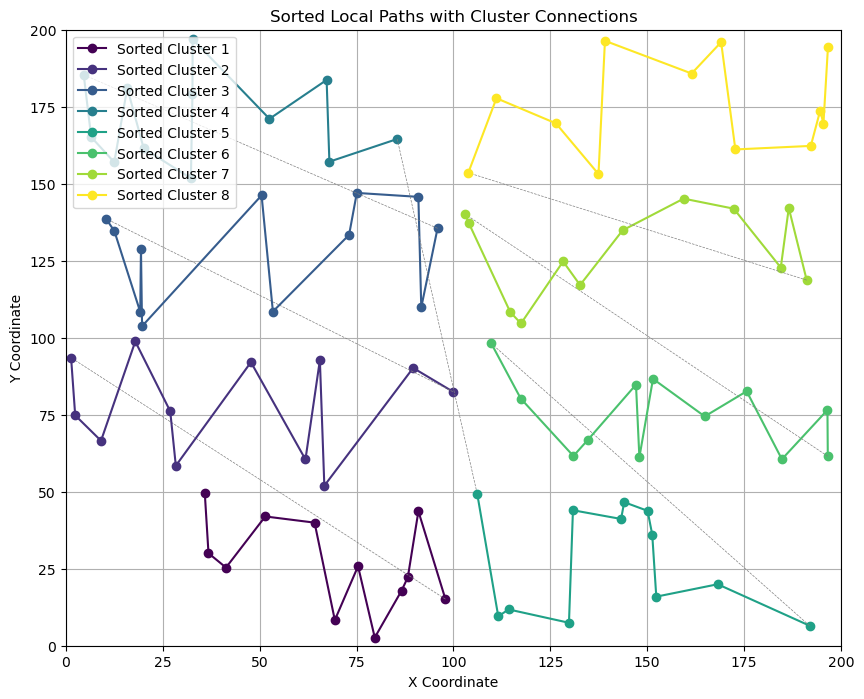

Optimal path for the general TSP:
[[ 17.90498781  98.79124593]
 [ 19.65318297 103.74194501]
 [ 19.1849537  108.38428523]
 [ 19.37200892 128.92739712]
 [ 20.08695041 161.44170196]
 [ 32.25536721 151.77630004]
 [ 50.49856447 146.22363773]
 [ 67.99558062 157.15812598]
 [ 75.07359579 147.01483128]
 [ 73.07907208 133.3966851 ]
 [ 95.91045842 135.53039743]
 [ 90.95881059 145.73439968]
 [103.84665678 153.56803073]
 [103.03939579 140.11752848]
 [103.98593045 137.18835509]
 [128.31350503 124.75908799]
 [132.68602505 117.10586225]
 [114.68160802 108.295491  ]
 [117.44187246 104.62813867]
 [109.76720408  98.15491418]
 [ 91.70791457 109.85455438]
 [ 89.61163254  90.18776247]
 [ 99.86655187  82.49318935]
 [117.374088    80.26150962]
 [106.16832815  49.17002581]
 [ 90.96706558  43.64802923]
 [ 75.38962084  25.81169116]
 [ 69.40205818   8.32619442]
 [ 79.70559955   2.6561614 ]
 [ 86.63030282  17.88549048]
 [ 88.23546213  22.19830298]
 [ 97.94319362  15.1225252 ]
 [111.5742012    9.54659152]
 [114.251

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from python_tsp.heuristics import solve_tsp_simulated_annealing
from scipy.spatial.distance import pdist, squareform
from itertools import chain

# Get user inputs for the coordinate limit, number of computers, and number of nodes
coordinate = int(input("Enter the coordinate limit (e.g., 200): "))
computers = int(input("Enter the number of computers (e.g., 10): "))
nodes = int(input("Enter the number of nodes (e.g., 500): "))

# Function to generate random node coordinates within specified limits
def generate_nodes():
    full_coordinates = np.empty((0, 2), float)
    x_section_arr = np.linspace(0, coordinate, 3)
    y_section_arr = np.linspace(0, coordinate, num=int(3 + ceil((computers - 4) / 2)))

    nodes_per_computer = max(1, nodes // computers)  # Ensure at least 1 node per computer
    for x_section in range(len(x_section_arr) - 1):
        for y_section in range(len(y_section_arr) - 1):
            x_nodes_coord = np.random.uniform(
                int(x_section_arr[x_section]),
                int(x_section_arr[x_section + 1]),
                size=(nodes_per_computer, 1)
            )
            y_nodes_coord = np.random.uniform(
                int(y_section_arr[y_section]),
                int(y_section_arr[y_section + 1]),
                size=(nodes_per_computer, 1)
            )
            col = np.column_stack((x_nodes_coord, y_nodes_coord))
            full_coordinates = np.append(full_coordinates, col, axis=0)

    return full_coordinates

# Function to calculate the distance matrix
def calcute_distance(arr):
    return squareform(pdist(arr, metric='euclidean'))

# Function for optimizing the individual paths using TSP
def optimize_local_paths(full_coordinates):
    local_paths = []
    for coords in full_coordinates:
        distance_matrix = calcute_distance(coords)
        permutation, _ = solve_tsp_simulated_annealing(distance_matrix)
        local_paths.append(coords[permutation])
    return local_paths

# Function to sort the nodes within each cluster and connect the highest node of one to the lowest node of the next
def sort_and_connect_clusters(local_paths):
    all_connections = []
    # Sort each cluster of nodes by x and y coordinates
    sorted_local_paths = []

    for path in local_paths:
        # Sort each cluster based on the x and y coordinates (low to high)
        sorted_path = path[np.lexsort((path[:, 1], path[:, 0]))]  # Sorting by x first, then by y
        sorted_local_paths.append(sorted_path)

    # Connect the highest node of each cluster to the lowest node of the next cluster
    for i in range(len(sorted_local_paths) - 1):
        # Get the highest node from the current cluster and the lowest node from the next cluster
        highest_node_current = sorted_local_paths[i][-1]
        lowest_node_next = sorted_local_paths[i + 1][0]

        # Add the connection between the highest node of the current cluster and the lowest node of the next
        all_connections.append((highest_node_current, lowest_node_next))

    return sorted_local_paths, all_connections

# Function to plot paths with connections between clusters
def plot_paths_with_connections(sorted_local_paths, connections):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_local_paths)))

    # Plot sorted local paths and connections between clusters
    for i, path in enumerate(sorted_local_paths):
        plt.plot(path[:, 0], path[:, 1], marker='o', color=colors[i], label=f'Sorted Cluster {i + 1}')
        # Plot the connections between clusters
        if i < len(connections):
            conn = connections[i]
            plt.plot([conn[0][0], conn[1][0]], [conn[0][1], conn[1][1]], color='gray', linestyle='--', linewidth=0.5)

    plt.scatter(all_coordinates[:, 0], all_coordinates[:, 1], color='black', s=10)
    plt.title('Sorted Local Paths with Cluster Connections')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left')
    plt.xlim(0, coordinate)
    plt.ylim(0, coordinate)
    plt.grid(True)
    plt.show()

# Function to create a general TSP from sorted paths and connections
def create_general_tsp(sorted_local_paths, connections):
    # Extract all unique points from sorted paths and add the connection points
    all_points = {tuple(point) for path in sorted_local_paths for point in path}
    for conn in connections:
        all_points.add(tuple(conn[0]))  # Add start of the connection
        all_points.add(tuple(conn[1]))  # Add end of the connection

    # Convert the set back to a numpy array
    all_points = np.array(list(all_points))

    # Calculate the distance matrix for the general TSP
    distance_matrix = calcute_distance(all_points)

    return distance_matrix, all_points

# Main execution block
if __name__ == '__main__':
    all_coordinates = generate_nodes()
    full_coordinates = np.array_split(all_coordinates, computers)

    # Optimize local paths for each computer
    local_paths = optimize_local_paths(full_coordinates)

    # Sort clusters and connect the highest node of each cluster to the lowest node of the next
    sorted_local_paths, connections = sort_and_connect_clusters(local_paths)

    # Plot all sorted local paths with cluster connections
    plot_paths_with_connections(sorted_local_paths, connections)

    # Create the general TSP from sorted local paths and connections
    distance_matrix, all_points = create_general_tsp(sorted_local_paths, connections)

    # Solve the general TSP
    permutation, _ = solve_tsp_simulated_annealing(distance_matrix)

    # Rearranging the all_points based on the permutation
    optimal_path = all_points[permutation]

    # Print the optimal path for the general TSP
    print("Optimal path for the general TSP:")
    print(optimal_path)
